In [32]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
import glob
import gc

from importlib import reload
import stilutils.utils.denoisers as ut
reload(ut)

NMFDenoiser = ut.NMFDenoiser
SVDDenoiser = ut.SVDDenoiser
PercentileDenoiser = ut.PercentileDenoiser

plt.rcParams['figure.figsize'] = (15, 15)

In [2]:
def load_lst_as_np(input_lst: str, top=None):
    """Loads list of images as np array"""
    
    folder = input_lst.rsplit('/')[-2]
    if folder == 's1p5':
        datapath = 'entry_1/data_1/data'
    elif folder == 'c1_p':
        datapath = 'data/data'
    else:
        raise TypeError(f'must provide either c1_p or s1p5 input list, you provided {input_lst}')
    
    if top is None:
        top = int(1e10)

    from collections import defaultdict
    
    
    images = defaultdict(lambda: set())
    with open(input_lst) as fin_lst:
        for line in fin_lst:
            imagename, eventnum = line.replace('//','').split()
            images[imagename].add(int(eventnum))
    
    answ = []
    for image in images:
        idx = sorted(list(images[image]))
        full_image_path = f'{input_lst.rsplit("/", 1)[0]}/{image}'
        
        idx = idx[:top]

        with h5py.File(full_image_path, 'r') as f:
            answ.append(np.array(f[datapath][idx]))

    return np.vstack(answ)

def radial_profile(data, center=(720.057, 711.255)):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def calc_zero_percentage(arr2d):
    return (arr2d<0).sum() / arr2d.shape[0] / arr2d.shape[1]

def calc_zero_num(arr2d):
    return (arr2d<0).sum()

# S1P5 data (with high background)

In [3]:
%%time

# s1p5 = load_lst_as_np('raw_data/c1_p/indexed.lst', top=100)
s1p5 = load_lst_as_np('/home/marinegor/xtal/s1p5/images/raw_data/s1p5/indexed.lst', top=50)

s1p5.shape

CPU times: user 17.7 s, sys: 390 ms, total: 18.1 s
Wall time: 18.2 s


(50, 1440, 1440)

In [18]:
# s1p5_m = apply_mask(s1p5, center=(720, 710), radius=55)

In [29]:
percentile = PercentileDenoiser(alpha=1e-2)
nmf = NMFDenoiser()
svd = SVDDenoiser()

CPU times: user 1.24 s, sys: 50.1 ms, total: 1.29 s
Wall time: 1.29 s


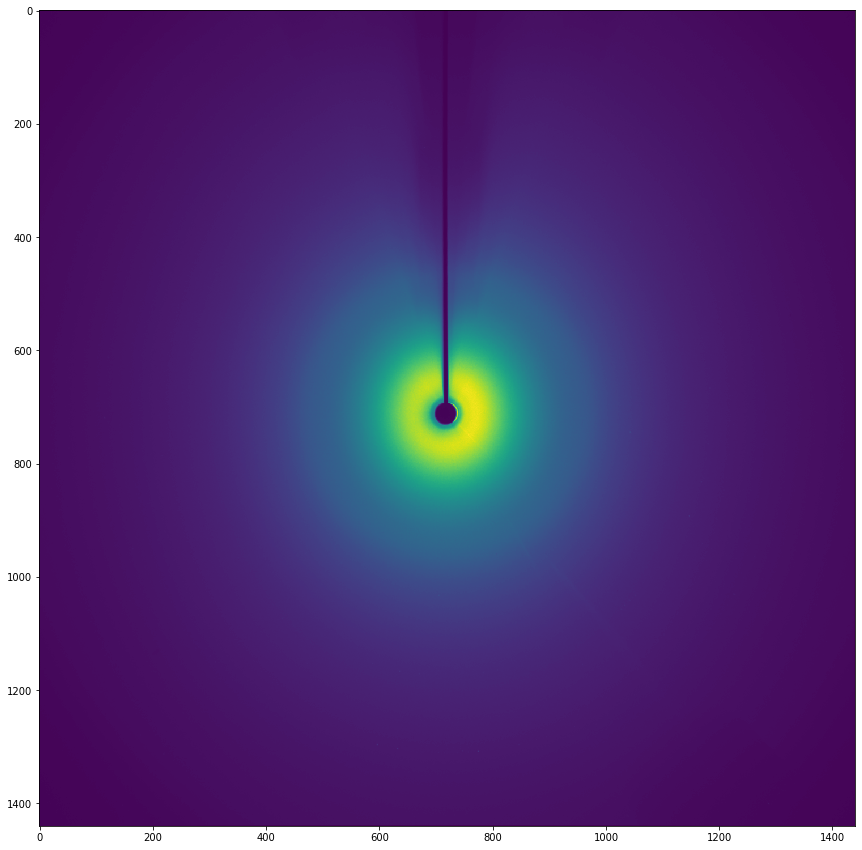

In [33]:
%%time

plt.imshow(percentile.fit(s1p5))

In [34]:
percentile.transform(s1p5, cent)

TypeError: transform() missing 1 required positional argument: 'center'

/home/marinegor/.local/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


TypeError: Invalid shape (2073600,) for image data

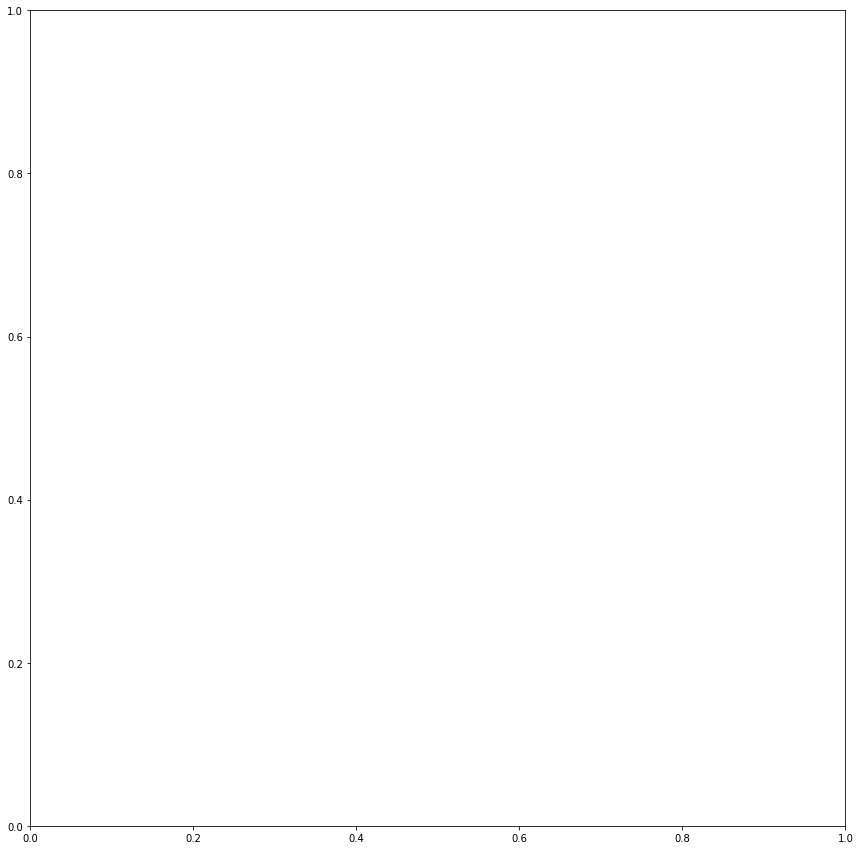

In [31]:
%%time

plt.imshow(nmf.fit(s1p5, center=(720, 710)))

In [5]:
nmf = NMFDenoiser()
percentile = PercentileDenoiser(alpha=0.01)
svd = SVDDenoiser()

In [54]:
%%time

s1p5_percentile_5 = PercentileDenoiser(alpha=5e-2).denoise(s1p5, center=(720, 710), radius=55)
s1p5_percentile_1 = PercentileDenoiser(alpha=1e-2).denoise(s1p5, center=(720, 710), radius=55)
s1p5_percentile_01 = PercentileDenoiser(alpha=1e-3).denoise(s1p5, center=(720, 710), radius=55)

CPU times: user 1min 30s, sys: 23.7 s, total: 1min 54s
Wall time: 1min 54s


In [120]:
%%time

s1p5_percentile_1_1 = PercentileDenoiser(alpha=1e-2).denoise(s1p5_percentile_1, center=(720, 710), radius=55)

CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.2 s


In [55]:
%%time

s1p5_nmf = nmf.denoise(s1p5, center=(720, 710), radius=55)

/home/marinegor/.local/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


CPU times: user 8min 32s, sys: 3min 47s, total: 12min 19s
Wall time: 3min 31s


In [56]:
%%time

s1p5_svd = svd.denoise(s1p5, center=(720, 710), radius=55)

CPU times: user 45.5 s, sys: 33.2 s, total: 1min 18s
Wall time: 26.8 s


[24, 48, 26, 2, 16, 32, 31, 25, 19, 30]


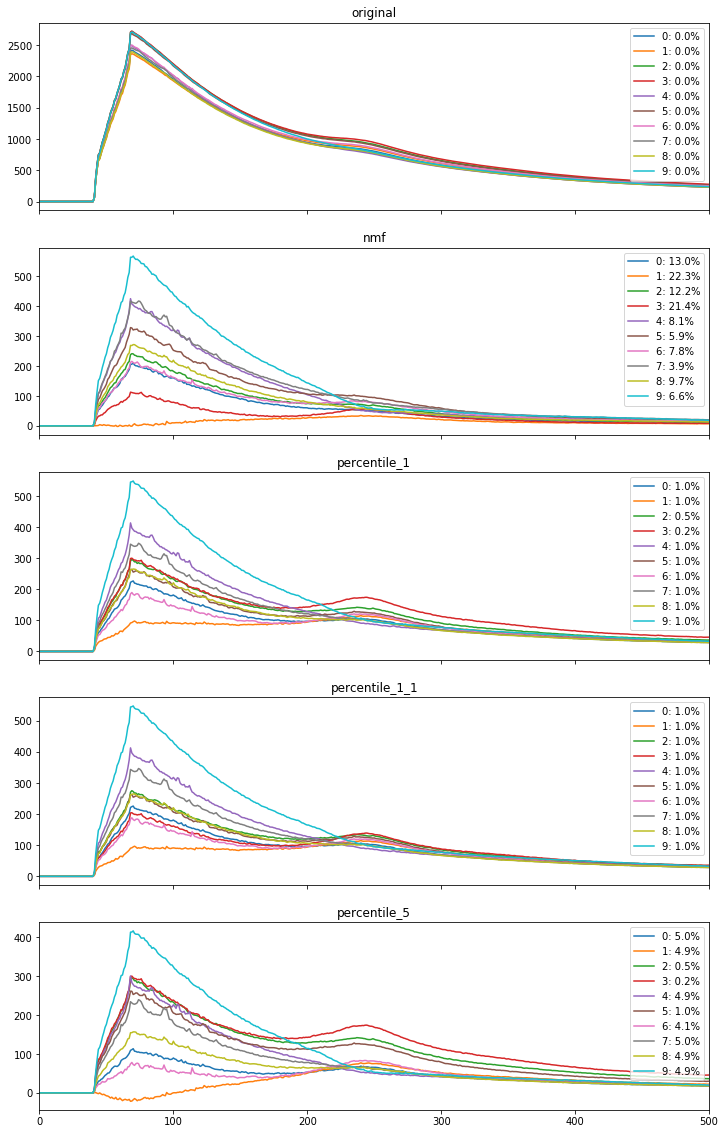

In [123]:
def plot_sample_profiles(images, seed=None, size=10, center=(720, 710), limit=None):
    import random
    random.seed(a=seed)
    
    arrs, labels = list(images.values()), list(images.keys())
    
    orig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (12, 4*len(arrs))
    
    n_arrs = len(arrs)
    
    if limit is None:
        limit = len(radial_profile(arrs[0]))
        
    arrs_idx = list(range(arrs[0].shape[0]))

    samples = [random.choice(arrs_idx) for _ in range(size)]
    print(samples)
    samples = [[arrs[i][idx] for i in range(n_arrs)] for idx in samples]
        
    fix, axs = plt.subplots(n_arrs, 1, sharex=True, sharey=False)
    
    for ax_id in range(n_arrs):
        for arr_id in range(size):
            arr = samples[arr_id][ax_id]
            axs[ax_id].plot(radial_profile(arr), 
                            label=f'{arr_id}: {calc_zero_percentage(arr)*100:.1f}%',
                           )
        if labels is not None:
            axs[ax_id].set_title(labels[ax_id])
        axs[ax_id].set_xlim((0, limit))
        axs[ax_id].legend(loc=1)

    plt.rcParams['figure.figsize'] = orig_size


data = {
    'original':s1p5_m,
#     'svd':s1p5_svd,
    'nmf':s1p5_nmf,
    'percentile_1':s1p5_percentile_1,
    'percentile_1_1':s1p5_percentile_1_1,
#     'percentile_01':s1p5_percentile_01,
    'percentile_5':s1p5_percentile_5,
}

plot_sample_profiles(images=data, seed=0, limit=500)

[24, 48, 26, 2, 16, 32, 31, 25, 19, 30]


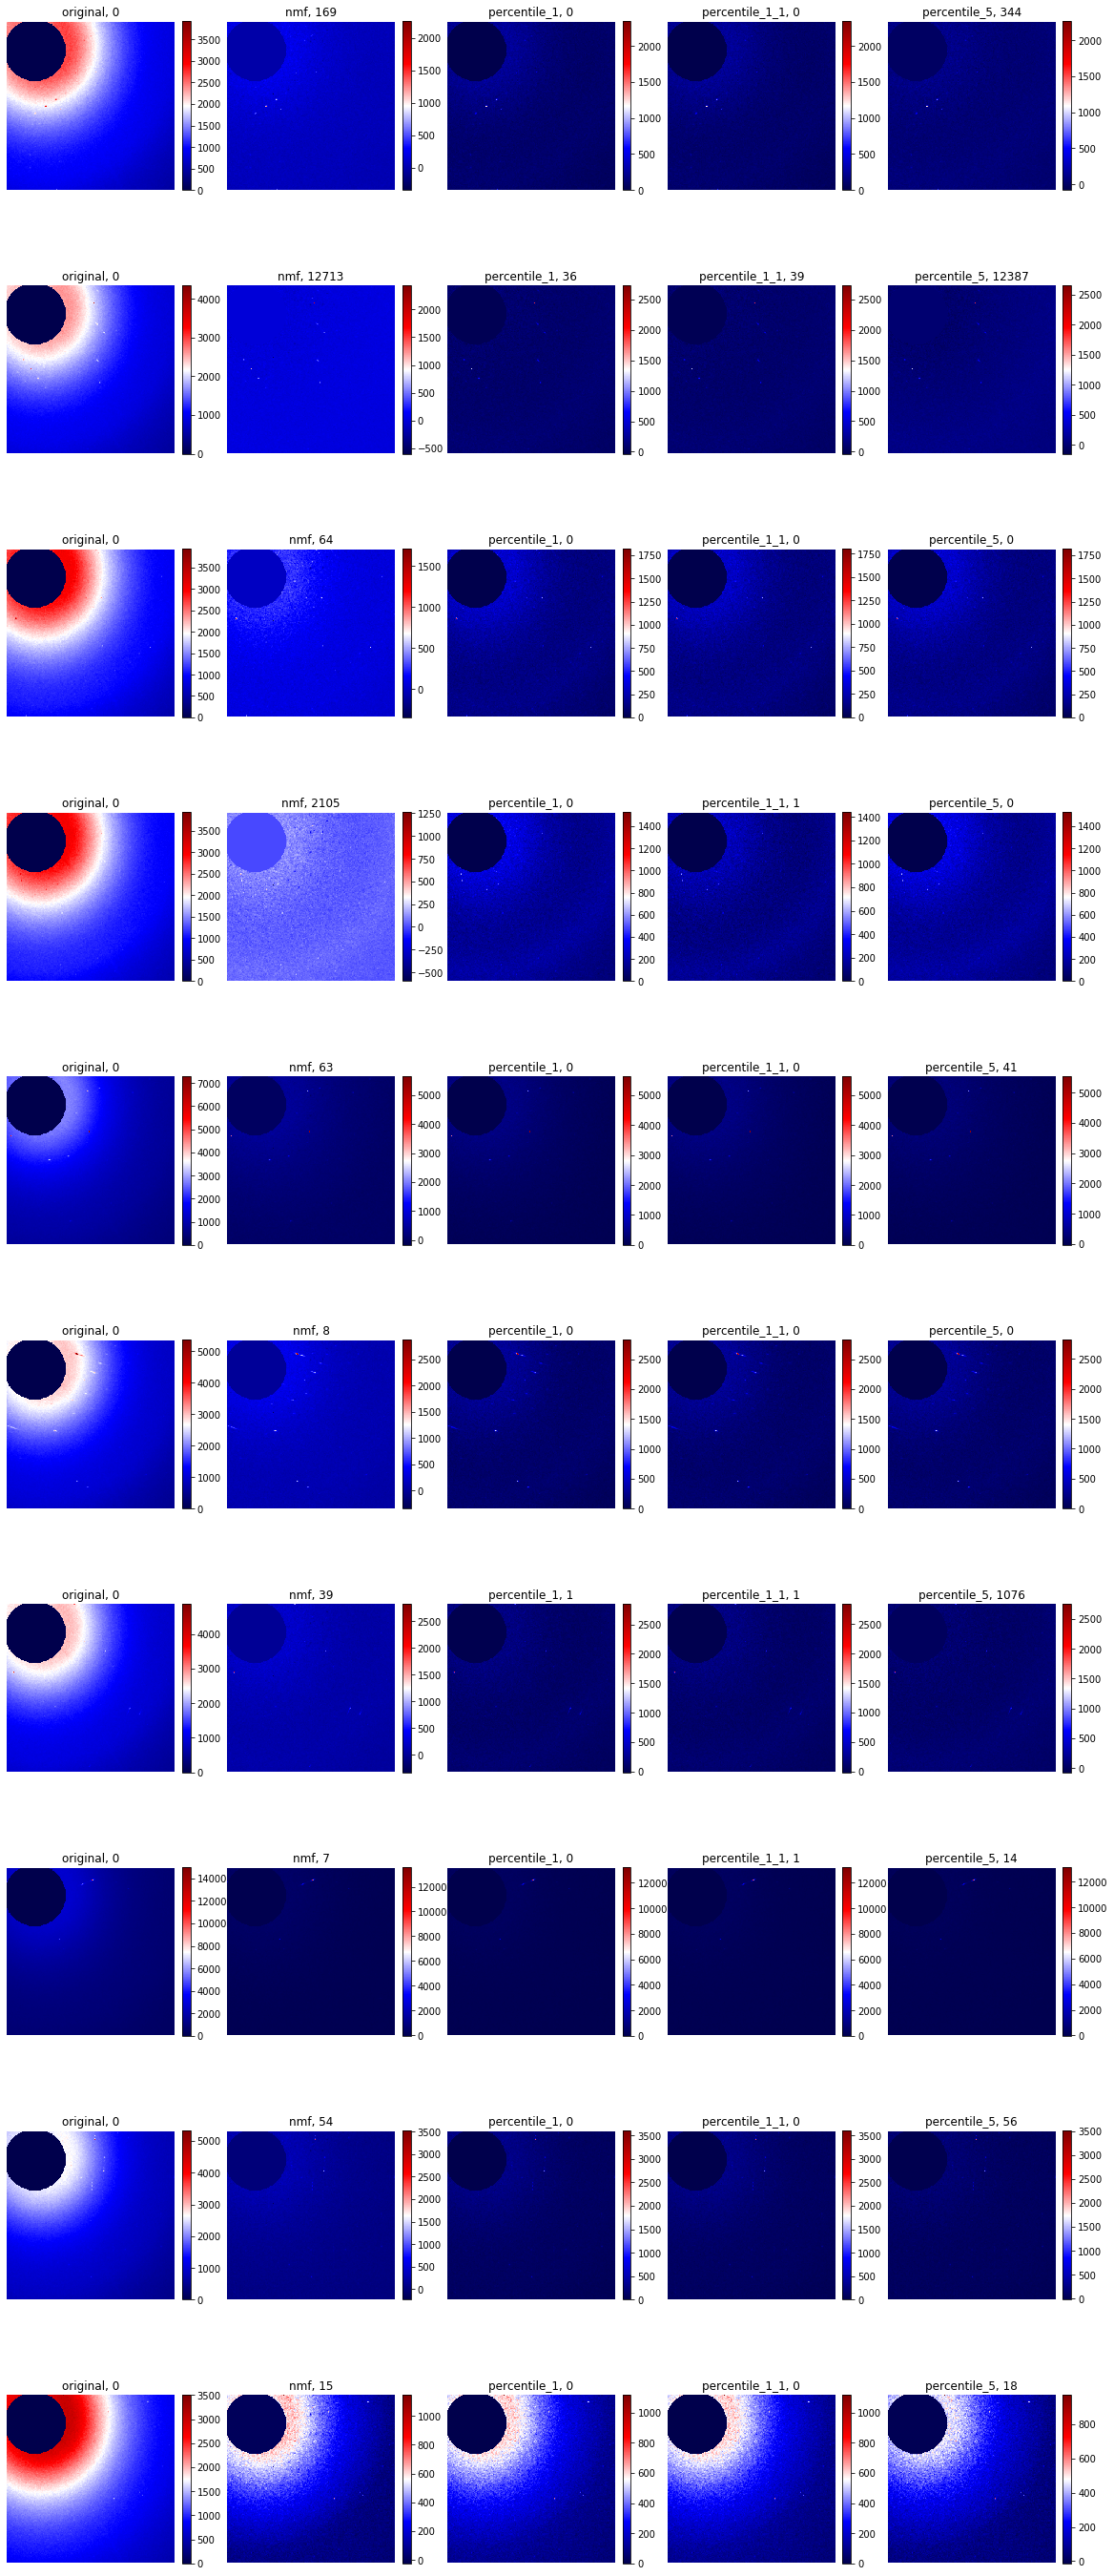

In [124]:
def plot_sample_images(images, 
                       size=5, 
                       seed=None,
                       center=(820, 810), 
                       side=(150, 150),
                      ):
    import random
    random.seed(a=seed)
    
    arrs, labels = list(images.values()), list(images.keys())
    x0 = center[0] - side[0]
    x1 = center[0] + side[0]
    y0 = center[1] - side[1]
    y1 = center[1] + side[1]
    n_arrs = len(arrs)

    orig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (4*n_arrs, 5*size)
    
        
    arrs_idx = list(range(arrs[0].shape[0]))
    samples = [random.choice(arrs_idx) for _ in range(size)]
    print(samples)
    samples = [[arrs[i][idx] for i in range(n_arrs)] for idx in samples]
        
    fig, axs = plt.subplots(size, n_arrs)
    
    for ax_id in range(n_arrs):
        for arr_id in range(size):
            arr = samples[arr_id][ax_id][x0:x1, y0:y1]
            ax = axs[arr_id][ax_id]
            
            im = ax.imshow(arr,
                           cmap='seismic',
                           )
            p = calc_zero_num(arr)
            ax.set_title(f'{labels[ax_id]}, {p:d}')
            fig.colorbar(im, fraction=0.046, pad=0.04, ax=ax)
            ax.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = orig_size


data = {
    'original':s1p5_m,
#     'svd':s1p5_svd,
    'nmf':s1p5_nmf,
    'percentile_1':s1p5_percentile_1,
    'percentile_1_1':s1p5_percentile_1_1,
#     'percentile_01':s1p5_percentile_01,
    'percentile_5':s1p5_percentile_5,
}

plot_sample_images(images=data, size=10, seed=0)

# c1_p data (without high background)

In [130]:
%%time

s1p5 = load_lst_as_np('/home/marinegor/xtal/s1p5/images/raw_data/c1_p/indexed.lst', top=50)
# s1p5 = load_lst_as_np('/home/marinegor/xtal/s1p5/images/raw_data/s1p5/indexed.lst', top=50)

s1p5.shape

CPU times: user 13.8 s, sys: 0 ns, total: 13.8 s
Wall time: 13.8 s


(50, 1440, 1440)

In [131]:
center=(717, 718)

s1p5_m = apply_mask(s1p5, center=center, radius=55)

In [132]:
nmf = NMFDenoiser()
svd = SVDDenoiser()

In [133]:
%%time

s1p5_percentile_5 = PercentileDenoiser(alpha=5e-2).denoise(s1p5, center=center, radius=55)
s1p5_percentile_1 = PercentileDenoiser(alpha=1e-2).denoise(s1p5, center=center, radius=55)
s1p5_percentile_01 = PercentileDenoiser(alpha=1e-3).denoise(s1p5, center=center, radius=55)

CPU times: user 1min 46s, sys: 30.8 s, total: 2min 17s
Wall time: 2min 23s


In [134]:
%%time

s1p5_percentile_1_1 = PercentileDenoiser(alpha=1e-2).denoise(s1p5_percentile_1, center=center, radius=55)

CPU times: user 10.2 s, sys: 2.65 s, total: 12.9 s
Wall time: 14.6 s


In [143]:
%%time

s1p5_nmf = nmf.denoise(np.abs(s1p5_m), center=center, radius=55)

/home/marinegor/.local/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


CPU times: user 6min 46s, sys: 2min 36s, total: 9min 22s
Wall time: 1min 38s


In [136]:
%%time

s1p5_svd = svd.denoise(s1p5, center=center, radius=55)

CPU times: user 29.5 s, sys: 22.5 s, total: 52 s
Wall time: 27.7 s


[24, 48, 26, 2, 16]


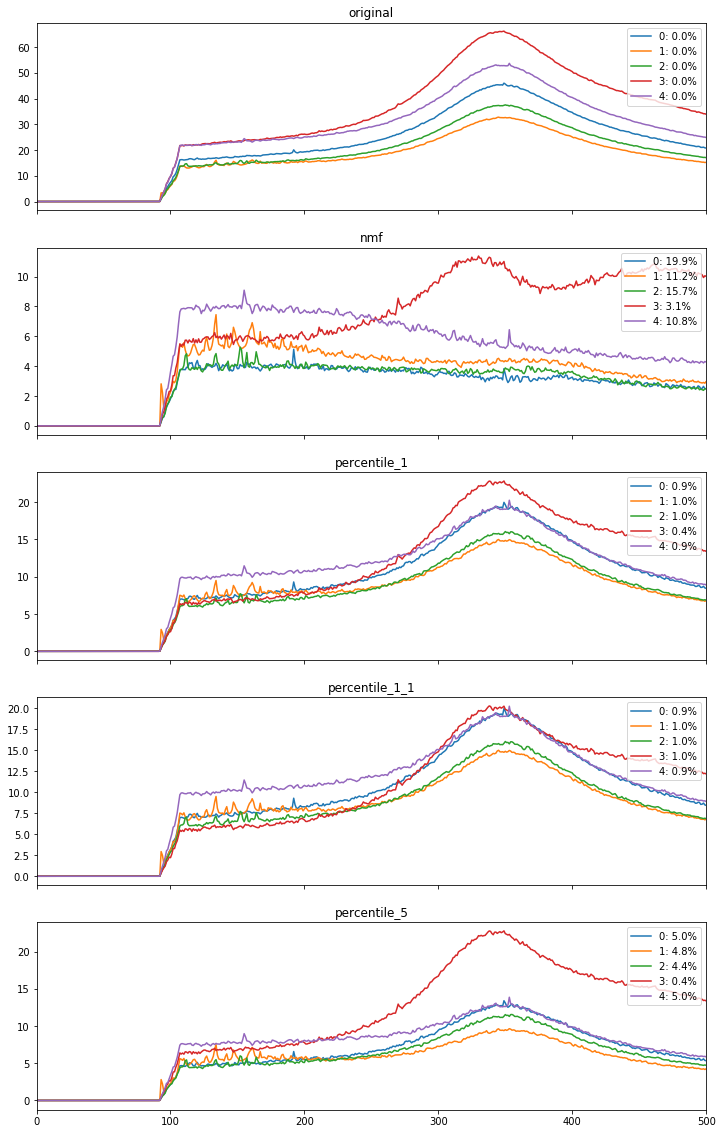

In [150]:
def plot_sample_profiles(images, seed=None, size=10, center=center, limit=None):
    import random
    random.seed(a=seed)
    
    arrs, labels = list(images.values()), list(images.keys())
    
    orig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (12, 4*len(arrs))
    
    n_arrs = len(arrs)
    
    if limit is None:
        limit = len(radial_profile(arrs[0]))
        
    arrs_idx = list(range(arrs[0].shape[0]))

    samples = [random.choice(arrs_idx) for _ in range(size)]
    print(samples)
    samples = [[arrs[i][idx] for i in range(n_arrs)] for idx in samples]
        
    fix, axs = plt.subplots(n_arrs, 1, sharex=True, sharey=False)
    
    for ax_id in range(n_arrs):
        for arr_id in range(size):
            arr = samples[arr_id][ax_id]
            axs[ax_id].plot(radial_profile(arr), 
                            label=f'{arr_id}: {calc_zero_percentage(arr)*100:.1f}%',
                           )
        if labels is not None:
            axs[ax_id].set_title(labels[ax_id])
        axs[ax_id].set_xlim((0, limit))
        axs[ax_id].legend(loc=1)

    plt.rcParams['figure.figsize'] = orig_size


data = {
    'original':s1p5_m,
#     'svd':s1p5_svd,
    'nmf':s1p5_nmf,
    'percentile_1':s1p5_percentile_1,
    'percentile_1_1':s1p5_percentile_1_1,
#     'percentile_01':s1p5_percentile_01,
    'percentile_5':s1p5_percentile_5,
}

plot_sample_profiles(images=data, size=5, seed=0, limit=500)

[8, 36, 48, 4, 16]


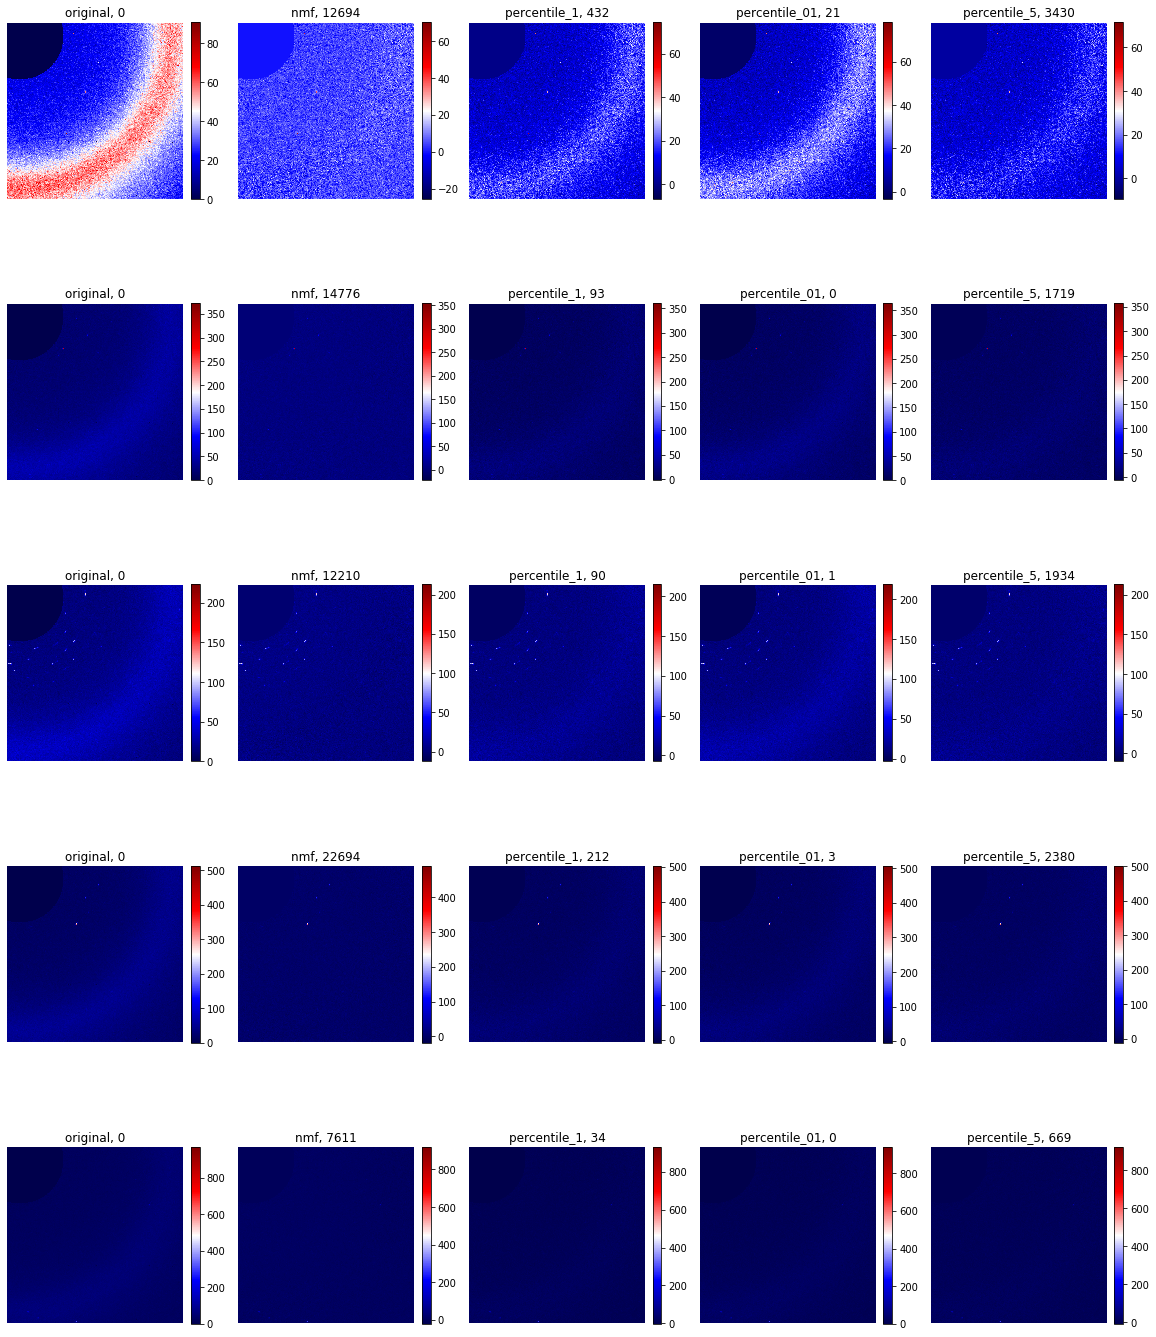

In [149]:
def plot_sample_images(images, 
                       size=5, 
                       seed=None,
                       center=(890, 890), 
                       side=(150, 150),
                      ):
    import random
    random.seed(a=seed)
    
    arrs, labels = list(images.values()), list(images.keys())
    x0 = center[0] - side[0]
    x1 = center[0] + side[0]
    y0 = center[1] - side[1]
    y1 = center[1] + side[1]
    n_arrs = len(arrs)

    orig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (4*n_arrs, 5*size)
    
        
    arrs_idx = list(range(arrs[0].shape[0]))
    samples = [random.choice(arrs_idx) for _ in range(size)]
    print(samples)
    samples = [[arrs[i][idx] for i in range(n_arrs)] for idx in samples]
        
    fig, axs = plt.subplots(size, n_arrs)
    
    for ax_id in range(n_arrs):
        for arr_id in range(size):
            arr = samples[arr_id][ax_id][x0:x1, y0:y1]
            ax = axs[arr_id][ax_id]
            
            im = ax.imshow(arr,
                           cmap='seismic',
                           )
            p = calc_zero_num(arr)
            ax.set_title(f'{labels[ax_id]}, {p:d}')
            fig.colorbar(im, fraction=0.046, pad=0.04, ax=ax)
            ax.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = orig_size


data = {
    'original':s1p5_m,
#     'svd':s1p5_svd,
    'nmf':s1p5_nmf,
    'percentile_1':s1p5_percentile_1,
#     'percentile_1_1':s1p5_percentile_1_1,
    'percentile_01':s1p5_percentile_01,
    'percentile_5':s1p5_percentile_5,
}

plot_sample_images(images=data, size=5, seed=1, side=(200, 200))